# GNN + Human Feedback (REINFORCE 방식) 추천 시스템 개발

# 1. 라이브러리 임포트

In [59]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.nn import HANConv

# 2. GNN 모델 정의

In [60]:
class HANPolicyRecommender(nn.Module):
    def __init__(self, metadata, hidden_dim=64):
        super().__init__()
        self.han_conv = HANConv(-1, hidden_dim, metadata=metadata, heads=2)
        self.policy_head = nn.Linear(hidden_dim, 1)  # 추천 확률 출력

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.han_conv(x_dict, edge_index_dict)
        return self.policy_head(x_dict['visit_area']).squeeze(-1)

# 3. 데이터 구성

In [61]:
data_path = "../data/"

def load_tensor(name):
    return torch.tensor(np.load(os.path.join(data_path, name)), dtype=torch.float if 'features' in name else torch.long)

user_x = load_tensor("user_features.npy")
travel_x = load_tensor("travel_features.npy")
visit_x = load_tensor("visit_features.npy")
edge_user_travel = load_tensor("edge_user_to_travel.npy")
edge_travel_visit = load_tensor("edge_travel_to_visit.npy")

## 3-1. HeteroData 구성

In [62]:
hetero_data = HeteroData()
hetero_data['user'].x = user_x
hetero_data['travel'].x = travel_x
hetero_data['visit_area'].x = visit_x
hetero_data[('user', 'traveled', 'travel')].edge_index = edge_user_travel
hetero_data[('travel', 'contains', 'visit_area')].edge_index = edge_travel_visit

In [63]:
for fname in os.listdir(data_path):
    if fname.startswith("edge_visit_move_") and fname.endswith(".npy"):
        move_type = fname.replace("edge_visit_move_", "").replace(".npy", "")
        edge_index = load_tensor(fname)
        hetero_data[('visit_area', f'move_{move_type}', 'visit_area')].edge_index = edge_index

metadata = hetero_data.metadata()
metadata

(['user', 'travel', 'visit_area'],
 [('user', 'traveled', 'travel'),
  ('travel', 'contains', 'visit_area'),
  ('visit_area', 'move_1', 'visit_area'),
  ('visit_area', 'move_2', 'visit_area'),
  ('visit_area', 'move_3', 'visit_area'),
  ('visit_area', 'move_6', 'visit_area'),
  ('visit_area', 'move_4', 'visit_area'),
  ('visit_area', 'move_5', 'visit_area')])

# 4. 모델, 옵티마이저 초기화

In [64]:
model = HANPolicyRecommender(metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. GNN 출력 → softmax 확률 변환 → 샘플링

In [65]:
model.eval()
with torch.no_grad():
    logits_before = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    temperature = 2.0  # softmax 분포를 완화하기 위한 온도 파라미터
    probs_before = F.softmax(logits_before / temperature, dim=0)
    top_before = torch.topk(probs_before, k=5)
    print("[정책 이전] 추천 Top-5 장소 index:", top_before.indices.tolist())

[정책 이전] 추천 Top-5 장소 index: [1509, 1510, 1512, 1511, 1508]


In [66]:
feedback_indices = top_before.indices.tolist()[2:3]  # 유저가 싫어한 추천 장소 인덱스
reward = -1.0  # 부정적 피드백

print("싫다고 한 것 : ", feedback_indices)

싫다고 한 것 :  [1512]


In [67]:
for idx in feedback_indices:
    for step in range(10):
        model.train()
        optimizer.zero_grad()
        logits = model(hetero_data.x_dict, hetero_data.edge_index_dict)
        probs = F.softmax(logits / temperature, dim=0)
        log_prob = torch.log(probs[idx])
        loss = -log_prob * reward
        loss.backward()
        optimizer.step()

# 6. REINFORCE 손실 계산 후 파라미터 업데이트

In [68]:
model.eval()
with torch.no_grad():
    logits_after = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    probs_after = F.softmax(logits_after / temperature, dim=0)
    top_after = torch.topk(probs_after, k=5)
    
print("[정책 이후] 추천 Top-5 장소 index:", top_after.indices.tolist())
print("보상 (reward):", reward)
print("REINFORCE loss:", round(loss.item(), 4))

[정책 이후] 추천 Top-5 장소 index: [850, 974, 866, 1040, 689]
보상 (reward): -1.0
REINFORCE loss: -9.6439


# 7.추천 확률 분포 시각화

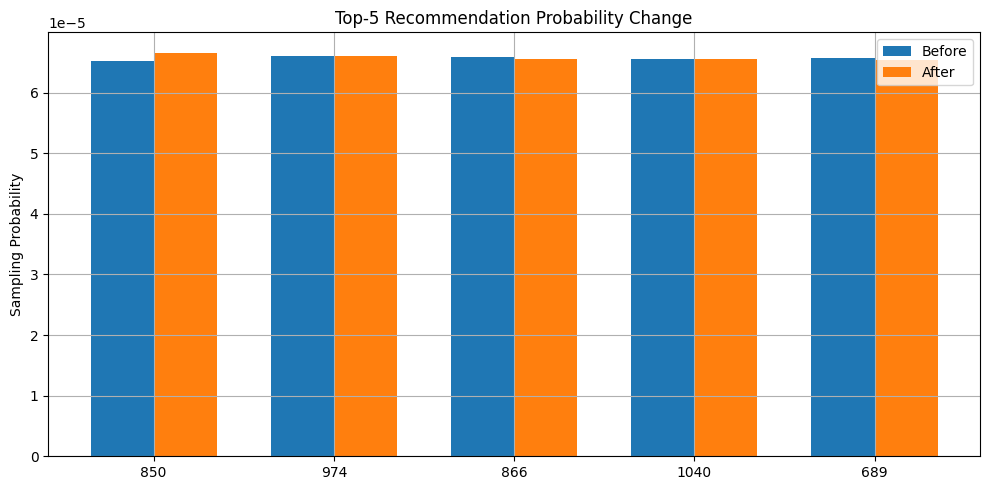

In [69]:
import matplotlib.pyplot as plt

indices = top_after.indices.tolist()
labels = [f"{i}" for i in indices]
before_vals = [probs_before[i].item() for i in indices]
after_vals = [probs_after[i].item() for i in indices]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, before_vals, width, label='Before')
ax.bar(x + width/2, after_vals, width, label='After')

ax.set_ylabel('Sampling Probability')  # Y축: 샘플링 확률
ax.set_title('Top-5 Recommendation Probability Change')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()  # 범례 표시
plt.grid(True)
plt.tight_layout()
plt.show()